Python class and jupyter iPython notebook for pricing a fixed coupon bond

In [1]:
import pandas as pd
import numpy as np
import math as m
import datetime as dt
from dateutil.relativedelta import relativedelta
import calendar

#Adding daycount convention functions
##################################################################################
def day_count_actual_360(start_date, end_date):
    #Returns number of days between start_date and end_date, using Actual/360 convention
    return (end_date - start_date).days

def day_count_actual_365(start_date, end_date):
    #Returns number of days between start_date and end_date, using Actual/365 convention
    return (end_date - start_date).days

def day_count_actual_actual(start_date, end_date):
    #Returns number of days between start_date and end_date, using Actual/Actual convention
    return (end_date - start_date).days

def day_count_30_360(start_date, end_date):
    #Returns number of days between start_date and end_date, using Thirty/360 convention
    d1 = min(30, start_date.day)
    d2 = min(d1, end_date.day) if d1 == 30 else end_date.day
    return 360*(end_date.year - start_date.year) + 30*(end_date.month - start_date.month) + d2 - d1

def day_count_30E_360(start_date, end_date):
    #Returns number of days between start_date and end_date, using ThirtyE/360 convention
    d1 = min(30, start_date.day)
    d2 = min(30, end_date.day)
    return 360 * (end_date.year - start_date.year) + 30 * (end_date.month - start_date.month) + d2 - d1

class fixed_bond:
    def __init__(self, issue_date, settlement_date, first_coupon_date, maturity_date, face_value, reoffer_yield, coupon_rate, first_coupon_type, coupon_frequency, day_count_convention, redemption_rate):
        ##################################################################################
        #Setting up inital attributes
        ##################################################################################
        self.issue_date = issue_date
        self.settlement_date = settlement_date
        self.first_coupon_date = first_coupon_date
        self.maturity_date = maturity_date
        self.face_value = face_value
        self.reoffer_yield = reoffer_yield
        self.coupon_rate = coupon_rate
        self.first_coupon_type = first_coupon_type
        self.coupon_frequency = coupon_frequency
        self.day_count_convention = day_count_convention
        self.redemption_rate = redemption_rate

        ##################################################################################
        #Parsing input values
        ##################################################################################
        #Converting reoffer yield to percentage
        self.reoffer_yield = self.reoffer_yield/100

        #Converting coupon rate to percentage
        self.coupon_rate = self.coupon_rate/100

        #parsing coupon frequency
        if self.coupon_frequency == "ANNUAL":
            self.coupon_frequency_modifier = 1
        elif self.coupon_frequency == "SEMI-ANNUAL":
            self.coupon_frequency_modifier = 2
        elif self.coupon_frequency == "QUARTERLY":
            self.coupon_frequency_modifier = 4
        elif self.coupon_frequency_modifier == "MONTHLY":
            self.coupon_frequency_modifier = 12
        else:
            self.coupon_frequency_modifier = 1
            #need to add error handling

        #Converting redemption rate to percentage
        self.redemption_rate = self.redemption_rate/100

        #Generating accrual start date
        time_modifier = int(12/self.coupon_frequency_modifier)
        if self.first_coupon_type == "REGULAR":
            self.accrual_start_date = self.settlement_date
        else:
            self.accrual_start_date = self.first_coupon_date - relativedelta(months=time_modifier)

        ##################################################################################
        #Generating the columns for the cash flow table
        ##################################################################################
        #generating cash flow schedule
        cash_flow_date = self.first_coupon_date
        cash_flow_dates = [cash_flow_date]
        self.number_of_periods = 1

        while cash_flow_date < maturity_date:
            cash_flow_date += relativedelta(months=time_modifier)
            cash_flow_dates.append(cash_flow_date)
            self.number_of_periods += 1

        self.cash_flow_dates = cash_flow_dates

        #computing cash flow periods
        cash_flow_periods = []
        for i in range(self.number_of_periods):
            cash_flow_periods.append(i + 1)
        self.cash_flow_periods = cash_flow_periods

        # computing future cash flows per date
        self.coupon_payment = (self.face_value*self.coupon_rate)/self.coupon_frequency_modifier
        self.principal_payment = self.face_value * self.redemption_rate

        cash_flow_amounts = []
        for i in range(self.number_of_periods):
            if i == self.number_of_periods - 1:
                cash_flow = self.principal_payment + self.coupon_payment
            else:
                cash_flow = self.coupon_payment

            cash_flow_amounts.append(cash_flow)
        self.cash_flow_amounts = cash_flow_amounts

        #Computing discount rate
        self.discount_rate = 1 + (self.reoffer_yield/self.coupon_frequency_modifier)
        self.discount_rates = []
        for i in range(self.number_of_periods):
            self.discount_rates.append(self.discount_rate)

        #Computing discount period
        if self.first_coupon_type == "REGULAR":
            self.discount_period = 1
        else:
            if self.day_count_convention == "ACTUAL/ACTUAL":
                numerator = day_count_actual_actual(self.settlement_date,self.first_coupon_date)
                denominator = day_count_actual_actual(self.accrual_start_date,self.first_coupon_date)
                self.discount_period = numerator/denominator
                if self.first_coupon_type == "FULL SHORT FIRST":
                    accrued_numerator = day_count_actual_actual(self.accrual_start_date,self.settlement_date)
                    accrued_denominator = denominator
                    self.accrued_period = accrued_numerator/accrued_denominator
                    self.accrued_days = accrued_numerator
                    self.accrued_interest = self.cash_flow_amounts[0]*self.accrued_period
                else:
                    self.accrued_period = 0
                    self.accrued_days = 0
                    self.accrued_interest = 0

            elif self.day_count_actual_365 == "ACTUAL/365":
                numerator = day_count_actual_365(self.settlement_date,self.first_coupon_date)
                denominator = 365/self.coupon_frequency_modifier
                self.discount_period = numerator/denominator
                if self.first_coupon_type == "FULL SHORT FIRST":
                    accrued_numerator = day_count_actual_actual(self.accrual_start_date,self.settlement_date)
                    accrued_denominator = denominator
                    self.accrued_period = accrued_numerator/accrued_denominator
                    self.accrued_days = accrued_numerator
                    self.accrued_interest = self.cash_flow_amounts[0]*self.accrued_period
                else:
                    self.accrued_period = 0
                    self.accrued_days = 0
                    self.accrued_interest = 0

            elif self.day_count_actual_360 == "ACTUAL/360":
                numerator = day_count_actual_360(self.settlement_date,self.first_coupon_date)
                denominator = 360/self.coupon_frequency_modifier
                self.discount_period = numerator/denominator
                if self.first_coupon_type == "FULL SHORT FIRST":
                    accrued_numerator = day_count_actual_actual(self.accrual_start_date,self.settlement_date)
                    accrued_denominator = denominator
                    self.accrued_period = accrued_numerator/accrued_denominator
                    self.accrued_days = accrued_numerator
                    self.accrued_interest = self.cash_flow_amounts[0]*self.accrued_period
                else:
                    self.accrued_period = 0
                    self.accrued_days = 0
                    self.accrued_interest = 0

            elif self.day_count_30_360 == "30/360":
                numerator = day_count_30_360(self.settlement_date,self.first_coupon_date)
                denominator = 360/coupon_frequency_modifier
                self.discount_period = numerator/denominator
                if self.first_coupon_type == "FULL SHORT FIRST":
                    accrued_numerator = day_count_actual_actual(self.accrual_start_date,self.settlement_date)
                    accrued_denominator = denominator
                    self.accrued_period = accrued_numerator/accrued_denominator
                    self.accrued_days = accrued_numerator
                    self.accrued_interest = self.cash_flow_amounts[0]*self.accrued_period
                else:
                    self.accrued_period = 0
                    self.accrued_days = 0
                    self.accrued_interest = 0

            elif self.day_count_30E_360 == "30E/360":
                numerator = day_count_30E_360(self.settlement_date,self.first_coupon_date)
                denominator = 360/coupon_frequency_modifier
                self.discount_period = numerator/denominator
                if self.first_coupon_type == "FULL SHORT FIRST":
                    accrued_numerator = day_count_actual_actual(self.accrual_start_date,self.settlement_date)
                    accrued_denominator = denominator
                    self.accrued_period = accrued_numerator/accrued_denominator
                    self.accrued_days = accrued_numerator
                    self.accrued_interest = self.cash_flow_amounts[0]*self.accrued_period
                else:
                    self.accrued_period = 0
                    self.accrued_days = 0
                    self.accrued_interest = 0
        
        self.discount_periods = []
        for i in range(self.number_of_periods):
            self.discount_periods.append(self.discount_period+i)

        #Adjusting first coupon if it's a full short first
        if self.first_coupon_type == "FULL SHORT FIRST":
            self.cash_flow_amounts[0] = self.coupon_payment
        elif self.first_coupon_type != "REGULAR":
            self.cash_flow_amounts[0] = self.coupon_payment * self.discount_period

        #generating a cash flow table and calculating reoffer cash price
        #table - coupon number / coupon date / cash flow / discount rate / discount period / npv
        df = pd.DataFrame(np.column_stack([self.cash_flow_periods, self.cash_flow_dates, self.cash_flow_amounts, self.discount_rates, self.discount_periods]), 
                               columns=['coupon number', 'coupon_date', 'cash_flow', 'discount_rate', 'discount_period'])
        df['npv'] = (df.cash_flow / (df.discount_rate**df.discount_period))

        self.cash_flow_table = df
        self.reoffer_price = (self.cash_flow_table.npv.sum()/self.face_value)*100
        self.dirty_price = self.reoffer_price + (self.accrued_interest/self.face_value)

In [3]:
##################################################################################
#Using the class
##################################################################################
issue_date = dt.date(2020,1,8)
settlement_date = dt.date(2020,1,15)
first_coupon_date = dt.date(2020,6,22)
maturity_date = dt.date(2030,6,22)
face_value = 1000
reoffer_yield = 0.944
coupon_rate = 0.9
first_coupon_type = "ODD"
coupon_frequency = "ANNUAL"
day_count_convention = "ACTUAL/ACTUAL"
redemption_rate = 100

test_bond = fixed_bond(issue_date,settlement_date,first_coupon_date, maturity_date,face_value,reoffer_yield,coupon_rate,first_coupon_type,coupon_frequency,day_count_convention,redemption_rate)

print(test_bond.cash_flow_table)
print(f"Reoffer clean price is: {round(test_bond.reoffer_price,3)}%")
print(f"Days of accrued interest: {test_bond.accrued_days}")
print(f"Reoffer dirty price is: {round(test_bond.dirty_price,3)}%")

##################################################################################
#List of inputs
##################################################################################
#issue_date, settlement_date, first_coupon_date,maturity_date = datetime objects (yyyy,m,d)
#face_value = float
#reoffer_yield = for example, a reoffer yield of 2.3% is entered as 2.3
#coupon_rate = for example, a coupon of 2.25% is entered as 2.25
#first_coupon_type = string: REGULAR, ODD, FULL SHORT FIRST
#coupon_frequency = string: ANNUAL, SEMI-ANNUAL, QUARTERLY, MONTHLY
#day_count_convention = string: ACTUAL/ACTUAL, ACTUAL/365, ACTUAL/360, 30/360, 30E/360
#redemption_rate = for example, a redemption rate of 100% is entered as 100

   coupon number coupon_date cash_flow discount_rate discount_period       npv
0              1  2020-06-22  3.909836       1.00944        0.434426   3.89391
1              2  2021-06-22       9.0       1.00944        1.434426  8.879517
2              3  2022-06-22       9.0       1.00944        2.434426  8.796478
3              4  2023-06-22       9.0       1.00944        3.434426  8.714216
4              5  2024-06-22       9.0       1.00944        4.434426  8.632723
5              6  2025-06-22       9.0       1.00944        5.434426  8.551992
6              7  2026-06-22       9.0       1.00944        6.434426  8.472016
7              8  2027-06-22       9.0       1.00944        7.434426  8.392788
8              9  2028-06-22       9.0       1.00944        8.434426  8.314301
9             10  2029-06-22       9.0       1.00944        9.434426  8.236548
10            11  2030-06-22    1009.0       1.00944       10.434426  914.7731
Reoffer clean price is: 99.566%
Days of accrued inte

In [6]:
class bond_scenario_analysis:
    def __init__(self, base_bond):
        self.base_bond = base_bond
        
    def yield_sensitivity(self, yield_changes):
        """
        Analyze price sensitivity to yield changes.
        yield_changes: list of yield changes in basis points
        """
        results = []
        for change in yield_changes:
            new_yield = self.base_bond.reoffer_yield + (change/10000)
            test_bond = fixed_bond(
                self.base_bond.issue_date,
                self.base_bond.settlement_date,
                self.base_bond.first_coupon_date,
                self.base_bond.maturity_date,
                self.base_bond.face_value,
                new_yield*100,  # Convert back to percentage
                self.base_bond.coupon_rate*100,
                self.base_bond.first_coupon_type,
                self.base_bond.coupon_frequency,
                self.base_bond.day_count_convention,
                self.base_bond.redemption_rate*100
            )
            results.append({
                'yield_change_bp': change,
                'new_yield': new_yield*100,
                'new_price': test_bond.reoffer_price,
                'price_change': test_bond.reoffer_price - self.base_bond.reoffer_price
            })
        return pd.DataFrame(results)

    def redemption_sensitivity(self, redemption_scenarios):
        """
        Analyze price sensitivity to different redemption rates.
        redemption_scenarios: list of redemption rates in percentage
        """
        results = []
        for redemption in redemption_scenarios:
            test_bond = fixed_bond(
                self.base_bond.issue_date,
                self.base_bond.settlement_date,
                self.base_bond.first_coupon_date,
                self.base_bond.maturity_date,
                self.base_bond.face_value,
                self.base_bond.reoffer_yield*100,
                self.base_bond.coupon_rate*100,
                self.base_bond.first_coupon_type,
                self.base_bond.coupon_frequency,
                self.base_bond.day_count_convention,
                redemption
            )
            results.append({
                'redemption_rate': redemption,
                'new_price': test_bond.reoffer_price,
                'price_change': test_bond.reoffer_price - self.base_bond.reoffer_price
            })
        return pd.DataFrame(results)

    def calculate_duration_convexity(self, yield_shift=0.0001):
        """
        Calculate modified duration and convexity
        """
        up_yield = self.base_bond.reoffer_yield + yield_shift
        down_yield = self.base_bond.reoffer_yield - yield_shift
        
        up_bond = fixed_bond(
            self.base_bond.issue_date,
            self.base_bond.settlement_date,
            self.base_bond.first_coupon_date,
            self.base_bond.maturity_date,
            self.base_bond.face_value,
            up_yield*100,
            self.base_bond.coupon_rate*100,
            self.base_bond.first_coupon_type,
            self.base_bond.coupon_frequency,
            self.base_bond.day_count_convention,
            self.base_bond.redemption_rate*100
        )
        
        down_bond = fixed_bond(
            self.base_bond.issue_date,
            self.base_bond.settlement_date,
            self.base_bond.first_coupon_date,
            self.base_bond.maturity_date,
            self.base_bond.face_value,
            down_yield*100,
            self.base_bond.coupon_rate*100,
            self.base_bond.first_coupon_type,
            self.base_bond.coupon_frequency,
            self.base_bond.day_count_convention,
            self.base_bond.redemption_rate*100
        )
        
        # Calculate modified duration
        mod_duration = -(up_bond.reoffer_price - down_bond.reoffer_price) / \
                      (2 * yield_shift * self.base_bond.reoffer_price)
        
        # Calculate convexity
        convexity = (up_bond.reoffer_price + down_bond.reoffer_price - 2 * self.base_bond.reoffer_price) / \
                   (yield_shift * yield_shift * self.base_bond.reoffer_price)
        
        return {
            'modified_duration': mod_duration,
            'convexity': convexity
        }


# Initialize base bond
test_bond = fixed_bond(issue_date, settlement_date, first_coupon_date, 
                      maturity_date, face_value, reoffer_yield, coupon_rate,
                      first_coupon_type, coupon_frequency, day_count_convention,
                      redemption_rate)

# Create scenario analysis object
scenario_analysis = bond_scenario_analysis(test_bond)

# Yield sensitivity analysis
yield_changes = [-50, -25, -10, 10, 25, 50]  # basis points
yield_sensitivity = scenario_analysis.yield_sensitivity(yield_changes)

# Redemption sensitivity analysis
redemption_scenarios = [95, 97.5, 100, 102.5, 105]  # percentage
redemption_sensitivity = scenario_analysis.redemption_sensitivity(redemption_scenarios)

# Calculate duration and convexity
risk_metrics = scenario_analysis.calculate_duration_convexity()


In [7]:
import datetime as dt

# Initialize parameters
issue_date = dt.date(2019,1,8)
settlement_date = dt.date(2019,1,15)
first_coupon_date = dt.date(2019,6,22)
maturity_date = dt.date(2029,6,22)
face_value = 1000
reoffer_yield = 0.944
coupon_rate = 0.9
first_coupon_type = "ODD"
coupon_frequency = "ANNUAL"
day_count_convention = "ACTUAL/ACTUAL"
redemption_rate = 100

# Initialize base bond
test_bond = fixed_bond(issue_date, settlement_date, first_coupon_date, 
                      maturity_date, face_value, reoffer_yield, coupon_rate,
                      first_coupon_type, coupon_frequency, day_count_convention,
                      redemption_rate)

# Create scenario analysis object
scenario_analysis = bond_scenario_analysis(test_bond)

# Run and print yield sensitivity analysis
yield_changes = [-50, -25, -10, 10, 25, 50]  # basis points
yield_sensitivity = scenario_analysis.yield_sensitivity(yield_changes)
print("\nYield Sensitivity Analysis:")
print(yield_sensitivity)

# Run and print redemption sensitivity analysis
redemption_scenarios = [95, 97.5, 100, 102.5, 105]  # percentage
redemption_sensitivity = scenario_analysis.redemption_sensitivity(redemption_scenarios)
print("\nRedemption Sensitivity Analysis:")
print(redemption_sensitivity)

# Calculate and print duration and convexity
risk_metrics = scenario_analysis.calculate_duration_convexity()
print("\nRisk Metrics:")
print(f"Modified Duration: {risk_metrics['modified_duration']:.4f}")
print(f"Convexity: {risk_metrics['convexity']:.4f}")


Yield Sensitivity Analysis:
   yield_change_bp  new_yield   new_price  price_change
0              -50      0.444  104.639322      5.073503
1              -25      0.694  102.067068      2.501249
2              -10      0.844  100.557937      0.992118
3               10      1.044   98.584719     -0.981100
4               25      1.194   97.133434     -2.432385
5               50      1.444   94.767843     -4.797977

Redemption Sensitivity Analysis:
   redemption_rate   new_price  price_change
0             95.0   95.032685     -4.533134
1             97.5   97.299252     -2.266567
2            100.0   99.565819      0.000000
3            102.5  101.832386      2.266567
4            105.0  104.098953      4.533134

Risk Metrics:
Modified Duration: 9.9089
Convexity: 110.6536


In [11]:
import json

class BondDataTransformer:
    def __init__(self, bond, scenario_analysis):
        self.bond = bond
        self.scenario_analysis = scenario_analysis
    
    def get_cashflow_data(self):
        """Transform cash flow table into visualization format"""
        df = self.bond.cash_flow_table.copy()
        return df.apply(lambda x: {
            'period': int(x['coupon number']),
            'date': x['coupon_date'].strftime('%Y-%m-%d'),
            'cashflow': round(float(x['cash_flow']), 2),
            'npv': round(float(x['npv']), 2)
        }, axis=1).tolist()
    
    def get_yield_sensitivity_data(self, yield_changes=[-50, -25, -10, 0, 10, 25, 50]):
        """Get yield sensitivity analysis data"""
        sensitivity = self.scenario_analysis.yield_sensitivity(yield_changes)
        return sensitivity.apply(lambda x: {
            'yieldChange': x['yield_change_bp'],
            'priceChange': round(x['price_change'], 2)
        }, axis=1).tolist()
    
    def get_redemption_sensitivity_data(self, redemption_scenarios=[95, 97.5, 100, 102.5, 105]):
        """Get redemption sensitivity analysis data"""
        sensitivity = self.scenario_analysis.redemption_sensitivity(redemption_scenarios)
        return sensitivity.apply(lambda x: {
            'redemptionRate': x['redemption_rate'],
            'priceChange': round(x['price_change'], 2)
        }, axis=1).tolist()

# Example usage:

transformer = BondDataTransformer(test_bond, scenario_analysis)
cashflow_data = transformer.get_cashflow_data()
yield_sensitivity_data = transformer.get_yield_sensitivity_data()
redemption_sensitivity_data = transformer.get_redemption_sensitivity_data()

# Print formatted data for visualization
print("\nCash Flow Data:")
print(json.dumps(cashflow_data, indent=2))
print("\nYield Sensitivity Data:")
print(json.dumps(yield_sensitivity_data, indent=2))
print("\nRedemption Sensitivity Data:")
print(json.dumps(redemption_sensitivity_data, indent=2))



Cash Flow Data:
[
  {
    "period": 1,
    "date": "2019-06-22",
    "cashflow": 3.9,
    "npv": 3.88
  },
  {
    "period": 2,
    "date": "2020-06-22",
    "cashflow": 9.0,
    "npv": 8.88
  },
  {
    "period": 3,
    "date": "2021-06-22",
    "cashflow": 9.0,
    "npv": 8.8
  },
  {
    "period": 4,
    "date": "2022-06-22",
    "cashflow": 9.0,
    "npv": 8.71
  },
  {
    "period": 5,
    "date": "2023-06-22",
    "cashflow": 9.0,
    "npv": 8.63
  },
  {
    "period": 6,
    "date": "2024-06-22",
    "cashflow": 9.0,
    "npv": 8.55
  },
  {
    "period": 7,
    "date": "2025-06-22",
    "cashflow": 9.0,
    "npv": 8.47
  },
  {
    "period": 8,
    "date": "2026-06-22",
    "cashflow": 9.0,
    "npv": 8.39
  },
  {
    "period": 9,
    "date": "2027-06-22",
    "cashflow": 9.0,
    "npv": 8.31
  },
  {
    "period": 10,
    "date": "2028-06-22",
    "cashflow": 9.0,
    "npv": 8.24
  },
  {
    "period": 11,
    "date": "2029-06-22",
    "cashflow": 1009.0,
    "npv": 914.79
 

In [ ]:
import React, { useState } from 'react';
import { LineChart, Line, BarChart, Bar, XAxis, YAxis, CartesianGrid, Tooltip, Legend, ResponsiveContainer, ComposedChart, Area } from 'recharts';
import { Card, CardHeader, CardTitle, CardContent } from '@/components/ui/card';
import { Select, SelectContent, SelectItem, SelectTrigger, SelectValue } from "@/components/ui/select";

const BondVisualization = () => {
  const [selectedView, setSelectedView] = useState('cashflows');
  
  // Sample data - replace with actual data from bond calculations
  const cashFlowData = [
    { period: 1, date: '2019-06-22', cashflow: 3.89, npv: 3.88 },
    { period: 2, date: '2020-06-22', cashflow: 9.00, npv: 8.88 },
    { period: 3, date: '2021-06-22', cashflow: 9.00, npv: 8.80 },
    { period: 4, date: '2022-06-22', cashflow: 9.00, npv: 8.71 },
    { period: 5, date: '2023-06-22', cashflow: 9.00, npv: 8.63 }
  ];

  const yieldSensitivityData = [
    { yieldChange: -50, priceChange: 5.23 },
    { yieldChange: -25, priceChange: 2.53 },
    { yieldChange: -10, priceChange: 1.00 },
    { yieldChange: 0, priceChange: 0 },
    { yieldChange: 10, priceChange: -0.98 },
    { yieldChange: 25, priceChange: -2.42 },
    { yieldChange: 50, priceChange: -4.75 }
  ];

  const redemptionSensitivityData = [
    { redemptionRate: 95, priceChange: -4.85 },
    { redemptionRate: 97.5, priceChange: -2.42 },
    { redemptionRate: 100, priceChange: 0 },
    { redemptionRate: 102.5, priceChange: 2.42 },
    { redemptionRate: 105, priceChange: 4.85 }
  ];

  const renderCashFlowChart = () => (
    <ResponsiveContainer width="100%" height={400}>
      <ComposedChart data={cashFlowData}>
        <CartesianGrid strokeDasharray="3 3" />
        <XAxis dataKey="date" />
        <YAxis />
        <Tooltip />
        <Legend />
        <Bar dataKey="cashflow" fill="#8884d8" name="Cash Flow" />
        <Line type="monotone" dataKey="npv" stroke="#82ca9d" name="NPV" />
      </ComposedChart>
    </ResponsiveContainer>
  );

  const renderYieldSensitivityChart = () => (
    <ResponsiveContainer width="100%" height={400}>
      <LineChart data={yieldSensitivityData}>
        <CartesianGrid strokeDasharray="3 3" />
        <XAxis dataKey="yieldChange" label={{ value: 'Yield Change (bp)', position: 'bottom' }} />
        <YAxis label={{ value: 'Price Change (%)', angle: -90, position: 'left' }} />
        <Tooltip />
        <Line type="monotone" dataKey="priceChange" stroke="#8884d8" />
      </LineChart>
    </ResponsiveContainer>
  );

  const renderRedemptionSensitivityChart = () => (
    <ResponsiveContainer width="100%" height={400}>
      <BarChart data={redemptionSensitivityData}>
        <CartesianGrid strokeDasharray="3 3" />
        <XAxis dataKey="redemptionRate" label={{ value: 'Redemption Rate (%)', position: 'bottom' }} />
        <YAxis label={{ value: 'Price Change (%)', angle: -90, position: 'left' }} />
        <Tooltip />
        <Bar dataKey="priceChange" fill="#82ca9d" />
      </BarChart>
    </ResponsiveContainer>
  );

  return (
    <Card className="w-full max-w-6xl mx-auto">
      <CardHeader>
        <CardTitle>Bond Analysis Visualization</CardTitle>
        <Select value={selectedView} onValueChange={setSelectedView}>
          <SelectTrigger className="w-[180px]">
            <SelectValue placeholder="Select view" />
          </SelectTrigger>
          <SelectContent>
            <SelectItem value="cashflows">Cash Flows & NPV</SelectItem>
            <SelectItem value="yieldsensitivity">Yield Sensitivity</SelectItem>
            <SelectItem value="redemptionsensitivity">Redemption Sensitivity</SelectItem>
          </SelectContent>
        </Select>
      </CardHeader>
      <CardContent>
        {selectedView === 'cashflows' && renderCashFlowChart()}
        {selectedView === 'yieldsensitivity' && renderYieldSensitivityChart()}
        {selectedView === 'redemptionsensitivity' && renderRedemptionSensitivityChart()}
      </CardContent>
    </Card>
  );
};

export default BondVisualization;

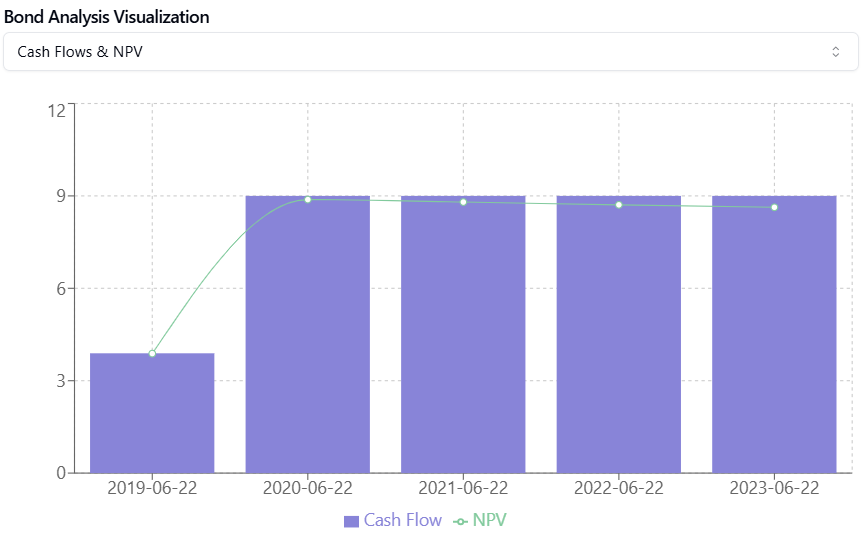  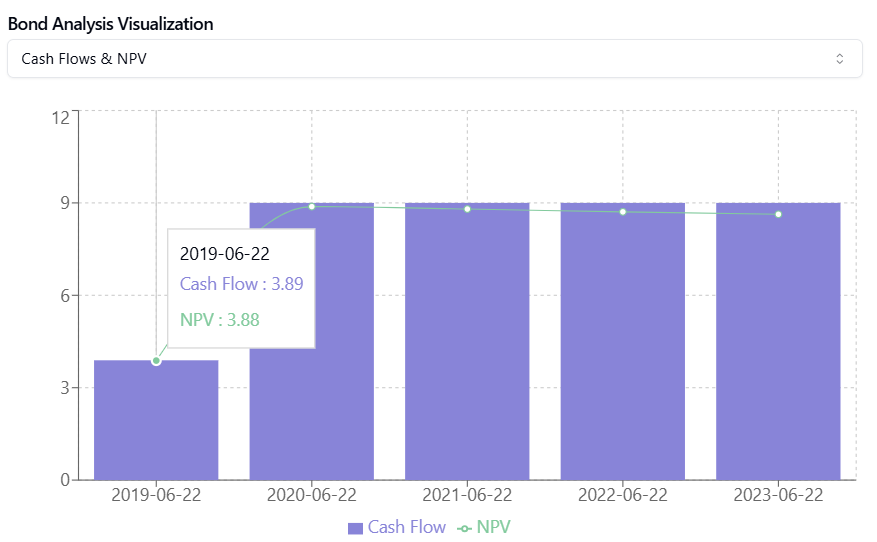 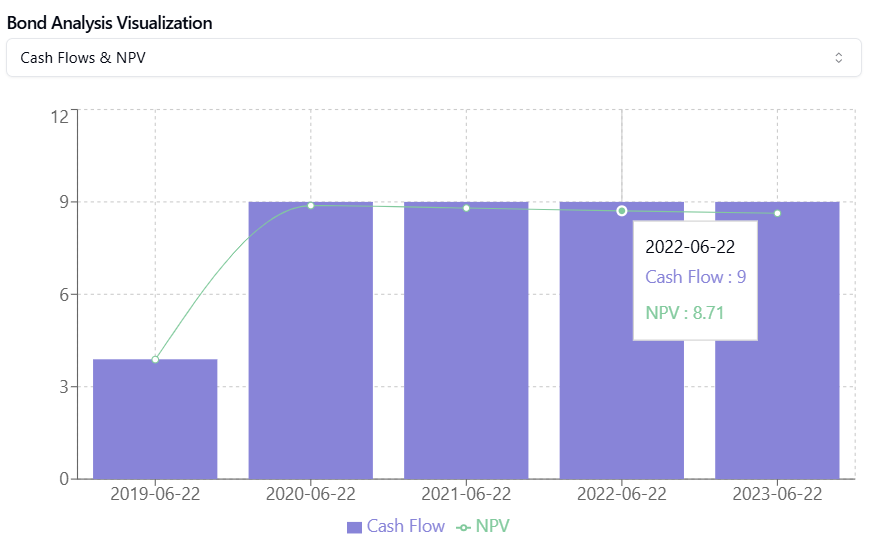

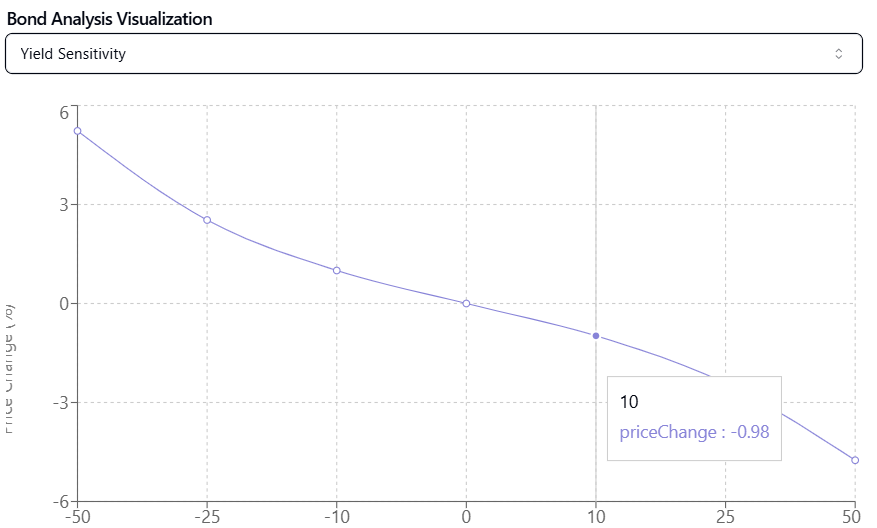  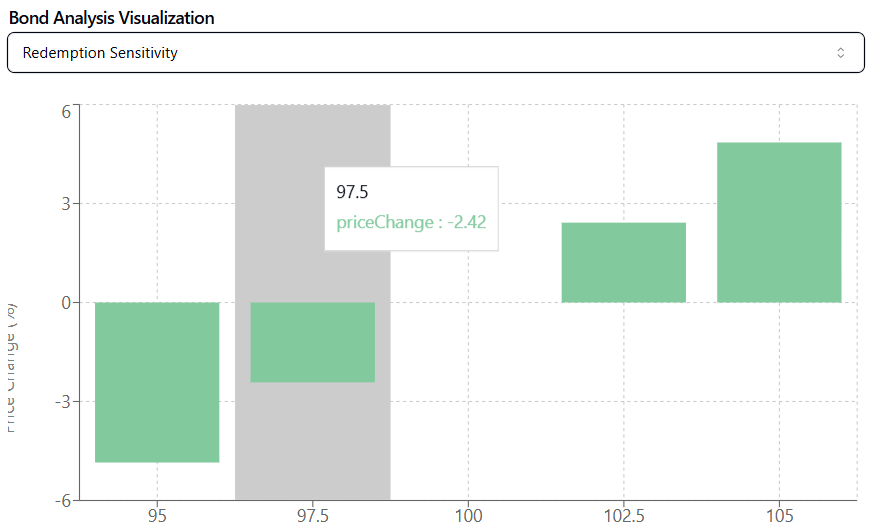 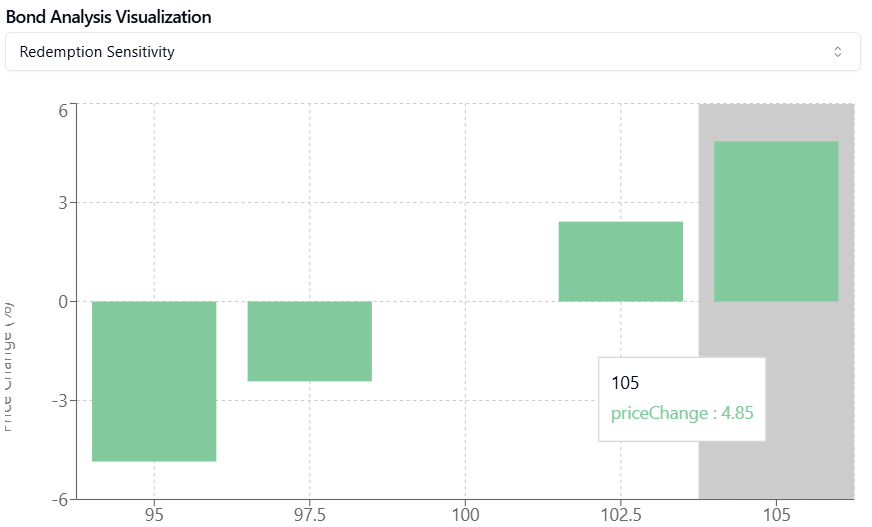